In [1]:
import numpy as np
import scipy.io

# random seed.
rand_seed = 2

from numpy.random import seed
seed(rand_seed)
from tqdm.keras import TqdmCallback
import tensorflow
tensorflow.random.set_seed(rand_seed)

import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, LSTM, Dense, Dropout, Flatten, Activation
from keras.layers.core import Permute, Reshape
from keras import backend as K

In [2]:
def one_hot_encoding(y_data):
    Mapping=dict()
    sub_dirs=['downstair','upstair','run','jump','walk','handwashing','exercise']

    categories=10
    count=0
    for i in sub_dirs:
        Mapping[i]=count
        count=count+1

    y_features2=[]
    for i in range(len(y_data)):
        Type=y_data[i]
        lab=Mapping[Type]
        y_features2.append(lab)

    y_features=np.array(y_features2)
    y_features=y_features.reshape(y_features.shape[0],1)
    from keras.utils import to_categorical
    y_features = to_categorical(y_features)

    return y_features

In [3]:
path='C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet/auto_data/'


def get_train_data(path=path):
    Train_data=np.load(path+'train_5000.npz')
    Features_imu=np.asarray(Train_data['arr_0'],dtype=np.float64)
    Labels=Train_data['arr_1']
    Features_sound=Train_data['arr_2']
    
    Labels = one_hot_encoding(Labels)
    Features_imu = Features_imu.reshape(Features_imu.shape[0],1, Features_imu.shape[1], Features_imu.shape[2]) 
    
    return Features_imu,Labels,Features_sound

def get_valid_data(path=path):
    Train_data=np.load(path+'valid_1000.npz')
    Features_imu=np.asarray(Train_data['arr_0'],dtype=np.float64)
    Labels=Train_data['arr_1']
    Features_sound=Train_data['arr_2']

    Labels = one_hot_encoding(Labels)
    Features_imu = Features_imu.reshape(Features_imu.shape[0],1, Features_imu.shape[1], Features_imu.shape[2]) 

    return Features_imu,Labels,Features_sound

def get_test_data(path=path):
    Train_data=np.load(path+'test_1377.npz')
    Features_imu=np.asarray(Train_data['arr_0'],dtype=np.float64)
    Labels=Train_data['arr_1']
    Features_sound=Train_data['arr_2']

    Labels = one_hot_encoding(Labels)
    Features_imu = Features_imu.reshape(Features_imu.shape[0],1, Features_imu.shape[1], Features_imu.shape[2]) 

    return Features_imu,Labels,Features_sound

In [4]:
Features_imu,Labels,Features_sound = get_train_data()
print(Features_imu.shape, Labels.shape, Features_sound.shape)
print('Train Classes distribution: ',np.sum(Labels, axis =0))

Features_imu2,Labels2,Features_sound2 = get_valid_data()
print(Features_imu2.shape, Labels2.shape, Features_sound2.shape)
print('Valid Classes distribution: ',np.sum(Labels2, axis =0))

Features_imu3,Labels3,Features_sound3 = get_test_data()
print(Features_imu3.shape, Labels3.shape, Features_sound3.shape)
print('Test Classes distribution: ',np.sum(Labels3, axis =0))


(5000, 1, 40, 12) (5000, 7) (5000, 193)
Train Classes distribution:  [760. 994. 546. 780. 532. 732. 656.]
(1000, 1, 40, 12) (1000, 7) (1000, 193)
Valid Classes distribution:  [150. 188. 136. 141.  98. 157. 130.]
(1377, 1, 40, 12) (1377, 7) (1377, 193)
Test Classes distribution:  [219. 268. 124. 146. 143. 234. 243.]


# IMU Model

In [5]:
# With dropout in the network

num_feat_map = 32

_, dim, win_len, _, = Features_imu.shape
num_classes=7


def full_imu_model():  
    print('building the model ... ')        
    model = Sequential()
    model.add(Conv2D(num_feat_map, kernel_size=(1, 5),
                 activation='relu',
                  input_shape=(dim, win_len, 12),
                 padding='same'))
    model.add(MaxPooling2D(pool_size=(1, 2)))
    model.add(Conv2D(num_feat_map, kernel_size=(1, 5), activation='relu',padding='same'))
    model.add(MaxPooling2D(pool_size=(1, 2)))
    model.add(Flatten())
    model.add(Dense(256, name='DENSE_3'))
    model.add(Activation('relu', name = 'ACT_3'))
    model.add(Dropout(0.3))
    model.add(Dense(128, name='DENSE_2'))
    model.add(Activation('relu', name = 'ACT_2'))
    model.add(Dense(64, name='DENSE_1'))
    model.add(Activation('relu', name = 'ACT_1'))

    model.add(Dense(num_classes, activation='softmax', name = 'OUTPUT'))
    
    return model

In [6]:
IMU_model = full_imu_model()

building the model ... 


In [7]:
IMU_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 1, 40, 32)         1952      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1, 20, 32)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 20, 32)         5152      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 10, 32)         0         
_________________________________________________________________
flatten (Flatten)            (None, 320)               0         
_________________________________________________________________
DENSE_3 (Dense)              (None, 256)               82176     
_________________________________________________________________
ACT_3 (Activation)           (None, 256)               0

In [8]:
model_path = 'C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet/'


from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import Callback
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath=model_path, verbose=1,monitor='val_accuracy' ,save_best_only=True, save_weights_only=False)

In [9]:
batch_size = 128
epochs = 50
from keras import optimizers
from keras.optimizers import Adam

adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
IMU_model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer= adam,
              metrics=['accuracy'])

import time
start_time = time.time()

learning_hist = IMU_model.fit(Features_imu, Labels,
                    verbose=0,
                    epochs=epochs,
                        shuffle=True,
                    batch_size=batch_size,
                        callbacks=[checkpointer,TqdmCallback(verbose=2)],
                    validation_data=(Features_imu2, Labels2))

end_time = time.time()

print("---Time %s seconds ---" % (end_time - start_time))

0epoch [00:00, ?epoch/s]

  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00001: val_accuracy improved from -inf to 0.42400, saving model to C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\assets


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00002: val_accuracy improved from 0.42400 to 0.54800, saving model to C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\assets


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00003: val_accuracy improved from 0.54800 to 0.65300, saving model to C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\assets


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00004: val_accuracy improved from 0.65300 to 0.74500, saving model to C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\assets


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00005: val_accuracy improved from 0.74500 to 0.78200, saving model to C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\assets


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00006: val_accuracy improved from 0.78200 to 0.83100, saving model to C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\assets


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00007: val_accuracy improved from 0.83100 to 0.85300, saving model to C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\assets


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00008: val_accuracy improved from 0.85300 to 0.86500, saving model to C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\assets


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00009: val_accuracy improved from 0.86500 to 0.87700, saving model to C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\assets


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00010: val_accuracy improved from 0.87700 to 0.90200, saving model to C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\assets


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00011: val_accuracy did not improve from 0.90200


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00012: val_accuracy did not improve from 0.90200


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00013: val_accuracy improved from 0.90200 to 0.91600, saving model to C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\assets


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00014: val_accuracy improved from 0.91600 to 0.92400, saving model to C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\assets


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00015: val_accuracy did not improve from 0.92400


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00016: val_accuracy improved from 0.92400 to 0.92600, saving model to C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\assets


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00017: val_accuracy did not improve from 0.92600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00018: val_accuracy did not improve from 0.92600


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00019: val_accuracy improved from 0.92600 to 0.93100, saving model to C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\assets


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00020: val_accuracy did not improve from 0.93100


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00021: val_accuracy improved from 0.93100 to 0.93800, saving model to C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\assets


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00022: val_accuracy did not improve from 0.93800


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00023: val_accuracy did not improve from 0.93800


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00024: val_accuracy improved from 0.93800 to 0.93900, saving model to C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\assets


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00025: val_accuracy did not improve from 0.93900


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00026: val_accuracy did not improve from 0.93900


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00027: val_accuracy did not improve from 0.93900


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00028: val_accuracy did not improve from 0.93900


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00029: val_accuracy did not improve from 0.93900


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00030: val_accuracy did not improve from 0.93900


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00031: val_accuracy improved from 0.93900 to 0.94500, saving model to C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\assets


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00032: val_accuracy did not improve from 0.94500


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00033: val_accuracy improved from 0.94500 to 0.94900, saving model to C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\assets


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00034: val_accuracy did not improve from 0.94900


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00035: val_accuracy did not improve from 0.94900


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00036: val_accuracy did not improve from 0.94900


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00037: val_accuracy improved from 0.94900 to 0.95100, saving model to C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\
INFO:tensorflow:Assets written to: C:/Users/macro/Desktop/UCLA Class/CMActivities-DataSet\assets


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00038: val_accuracy did not improve from 0.95100


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00039: val_accuracy did not improve from 0.95100


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00040: val_accuracy did not improve from 0.95100


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00041: val_accuracy did not improve from 0.95100


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00042: val_accuracy did not improve from 0.95100


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00043: val_accuracy did not improve from 0.95100


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00044: val_accuracy did not improve from 0.95100


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00045: val_accuracy did not improve from 0.95100


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00046: val_accuracy did not improve from 0.95100


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00047: val_accuracy did not improve from 0.95100


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00048: val_accuracy did not improve from 0.95100


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00049: val_accuracy did not improve from 0.95100


  0%|          | 0.00/40.0 [00:00<?, ?batch/s]


Epoch 00050: val_accuracy did not improve from 0.95100
---Time 35.489938735961914 seconds ---


In [10]:
from keras.models import load_model

IMU_model = load_model(model_path)

In [11]:
#Train Accuracy
IMU_model.evaluate(Features_imu,Labels)

157/157 [==============================] - 0s 2ms/step - loss: 0.0143 - accuracy: 0.9966


[0.014308099634945393, 0.9965999722480774]

In [12]:
#valid Accuracy
IMU_model.evaluate(Features_imu2,Labels2)

32/32 [==============================] - 0s 2ms/step - loss: 0.1998 - accuracy: 0.9510


[0.19983795285224915, 0.9509999752044678]

In [13]:
#Test Accuracy
IMU_model.evaluate(Features_imu3,Labels3)

44/44 [==============================] - 0s 3ms/step - loss: 0.4488 - accuracy: 0.8991


[0.4488176703453064, 0.8990558981895447]

# Plotting

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


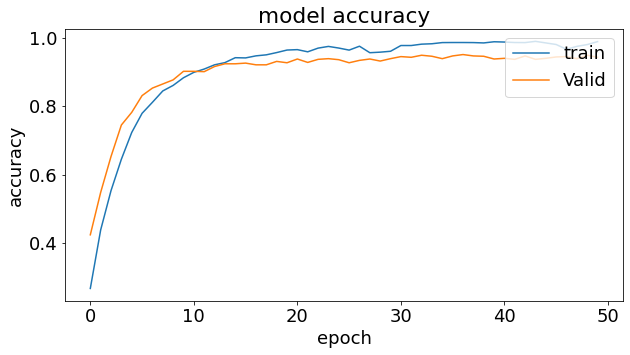

In [14]:
from matplotlib import pyplot as plt

print(learning_hist.history.keys())
plt.rcParams.update({'font.size': 18})

plt.figure(figsize=(10,5))

plt.plot(learning_hist.history['accuracy'])
plt.plot(learning_hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Valid'], loc='upper right')
plt.show()

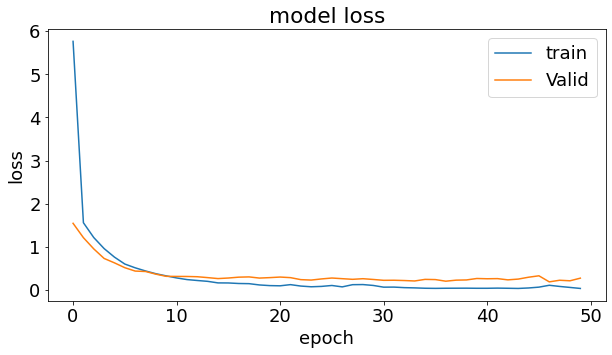

In [15]:
# summarize history for loss

from matplotlib import pyplot as plt

plt.figure(figsize=(10,5))
plt.rcParams.update({'font.size': 18})


plt.plot(learning_hist.history['loss'])
plt.plot(learning_hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Valid'], loc='upper right')
plt.show()

In [16]:
K.clear_session()